<a href="https://colab.research.google.com/github/phanisri2230/FMML_M1L1.ipynb/blob/main/FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [39]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

Let us borrow a few functions from the previous labs:

In [38]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [37]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

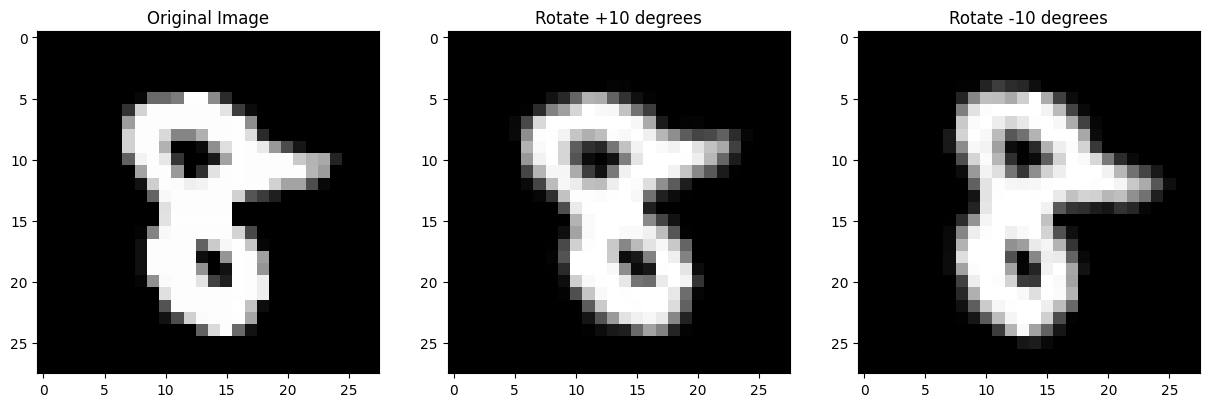

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [35]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

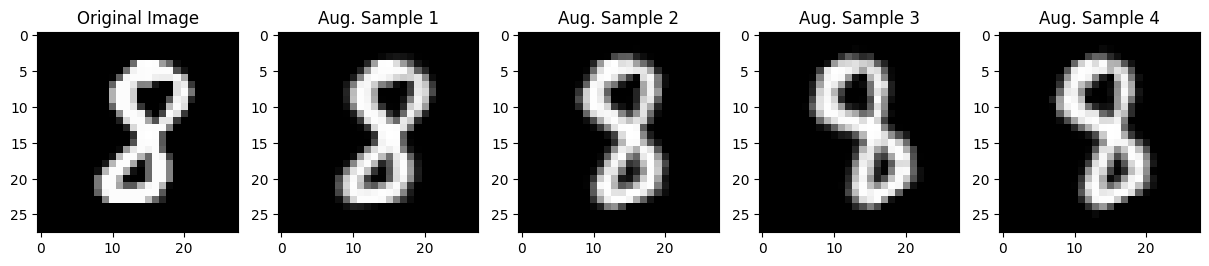

In [34]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [33]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 66.03999999999999 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [32]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.86 %
Accuracy after rotation augmentation constrained by 20 degrees is 68.15 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.37 %
Accuracy after rotation augmentation constrained by 40 degrees is 68.54 %
Accuracy after rotation augmentation constrained by 50 degrees is 66.74 %
Accuracy after rotation augmentation constrained by 60 degrees is 64.78 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.46 %
Accuracy after rotation augmentation constrained by 80 degrees is 66.64999999999999 %
Accuracy after rotation augmentation constrained by 90 degrees is 66.09 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

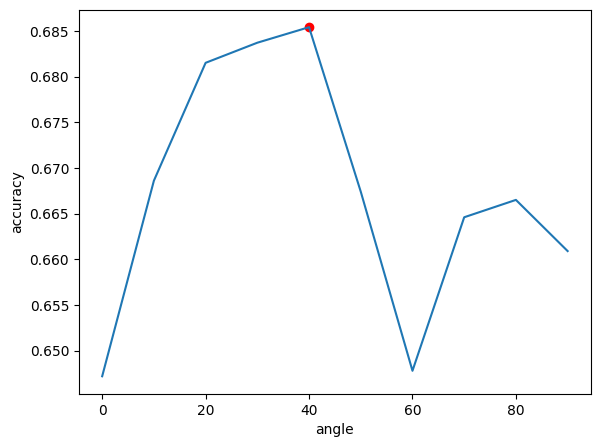

In [41]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [42]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

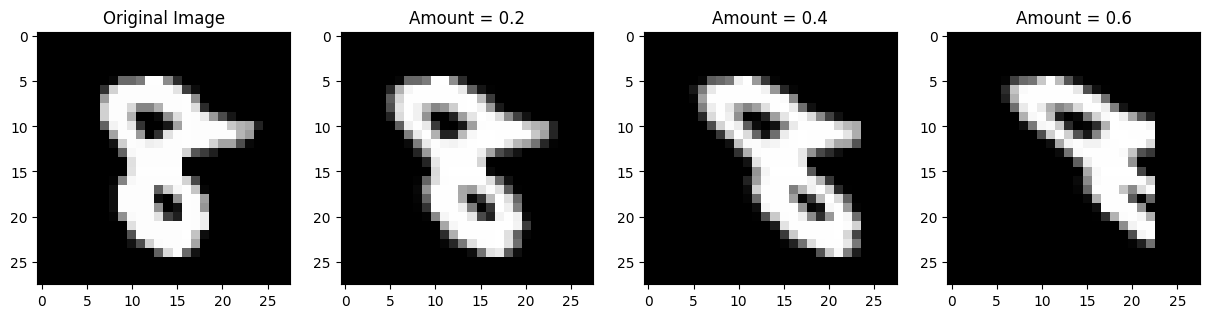

In [43]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [44]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [46]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 63.12 %
Accuracy after shear augmentation constrained by 0.4 is 64.38000000000001 %
Accuracy after shear augmentation constrained by 0.6 is 65.5 %
Accuracy after shear augmentation constrained by 0.8 is 66.25999999999999 %
Accuracy after shear augmentation constrained by 1.0 is 65.5 %
Accuracy after shear augmentation constrained by 1.2 is 64.95 %
Accuracy after shear augmentation constrained by 1.4 is 63.61 %
Accuracy after shear augmentation constrained by 1.6 is 65.03 %
Accuracy after shear augmentation constrained by 1.8 is 62.839999999999996 %
Accuracy after shear augmentation constrained by 2.0 is 62.77 %


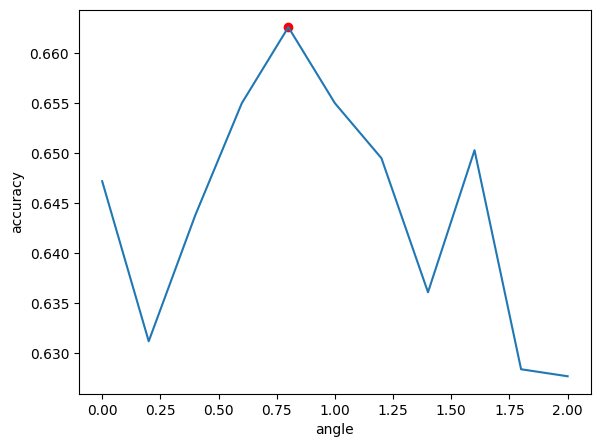

In [55]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [47]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

import numpy as np
from itertools import product

# Values we want to test
shearconstraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
angleconstraints = [0, 10, 20, 30, 40, 50, 60]

# Cartesian product of both
hyp = np.array(list(product(shearconstraints, angleconstraints)))

# Placeholder for accuracies
accuracies = np.zeros(len(hyp), dtype=float)

# Number of augmentations per configuration
naugmentations = 5  # Example value, adjust as needed

# Assuming train_X, train_y, test_X, and test_y are defined
for ii in range(len(hyp)):
    shear, angle = hyp[ii]

    # Create the augmented dataset
    augdata = train_X.copy()  # Start with original images
    auglabel = train_y.copy()
    
    for _ in range(naugmentations):
        # Augment data and concatenate to dataset
        augmented_images = augRotateShear(train_X, shear, angle)
        augdata = np.concatenate((augdata, augmented_images), axis=0)
        auglabel = np.concatenate((auglabel, train_y), axis=0)
    
    # Test the model
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)

    # Print the results
    print(
        f"Accuracy after augmentation shear: {shear}, angle: {angle} is {accuracies[ii]*100:.2f}%",
        flush=True,
    )

ValueError: cannot reshape array of size 11 into shape (11,10)

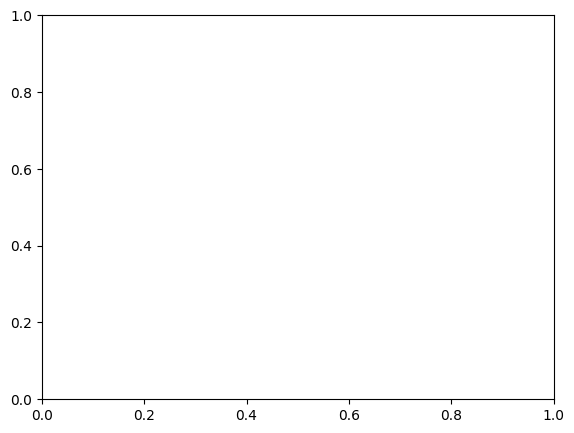

In [54]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
The "best value" for angle and shear constraints in the context of augmentations depends on the specific dataset and task, as well as the network architecture being used. However, some general observations can be made based on commonly used augmentations.

1. Angle Constraint: This usually refers to rotation or geometric transformations applied during augmentation. In many computer vision tasks (e.g., image classification, object detection), small angles (±15° to ±45°) often provide the best balance between increased data diversity and preserving object semantics. If the constraint is too high, it may distort the object in a way that makes the model's task harder.


2. Shear Constraint: This applies to shearing or affine transformations that change the perspective of the image. For tasks like object detection or segmentation, small to moderate shearing (e.g., ±10% to ±30%) tends to work best. Too much shear can distort objects to the point where the model cannot effectively learn from the data.



Accuracy Improvement with Augmentations

Without Augmentations: The model might struggle with overfitting or fail to generalize well to unseen variations in the data. The accuracy can be limited, especially if the dataset is small or lacks variability.

With Augmentations: When using augmentations like rotation, shear, and others (scaling, flipping, etc.), models typically experience a noticeable improvement in generalization, especially when the dataset is small or contains limited diversity. The increase in accuracy is typically observed in both training performance and validation accuracy.

Improvement Percentage: The actual improvement can vary, but augmentations have been shown to boost accuracy by 3-10% or more, depending on the complexity of the task and the initial model performance.



For example, for tasks like image classification or object detection, the use of augmentations like rotation (±30°) and shear (±15%) could lead to more robust models and better accuracy in scenarios where the original model might overfit to specific angles or distortions present in the training data.

In summary, small but effective constraints (±15° for angles and ±10-30% for shear) tend to provide a good balance, and augmentations generally improve model accuracy by 3-10% or more, depending on the task and dataset.


2. Can you increase the accuracy by increasing the number of augmentations from each sample?
Yes, increasing the number of augmentations from each sample can improve model accuracy, but the impact and effectiveness depend on the task, the model architecture, and the nature of the dataset. Here's a breakdown of how it works and when it might help:

How Increasing Augmentations Improves Accuracy:

1. Increased Variability: By applying more augmentations per sample, you create more diverse versions of each image. This helps the model learn more robust features that are invariant to transformations like rotation, scaling, flipping, or color adjustments.


2. Better Generalization: Augmentations act as a form of regularization. More augmented samples mean the model sees a wider variety of potential inputs, which can improve its ability to generalize to unseen data and reduce overfitting, especially in tasks with limited data.


3. Overcoming Data Scarcity: For smaller datasets, augmenting each sample multiple times can simulate a much larger dataset, allowing the model to better generalize without requiring more raw data.



Potential Drawbacks or Limits:

1. Diminishing Returns: After a certain point, applying too many augmentations per sample might not result in a significant improvement in accuracy. In some cases, excessive augmentation could lead to a model that becomes too generalized, losing important fine-grained features that distinguish different classes.


2. Training Time: More augmentations increase the number of training samples the model processes, which can lead to longer training times and higher computational cost, though this can be mitigated with techniques like online augmentation (performing augmentations on the fly).


3. Over-augmentation: If augmentations are too aggressive (e.g., extreme rotations, shearing, or flipping), the resulting images might become unrealistic or unrepresentative of real-world data, which could hurt accuracy rather than help it.



Best Practices:

Balanced Augmentation: It’s important to balance the variety of augmentations with the preservation of key features in the data. Apply a combination of rotations, shears, color adjustments, and noise, but avoid extreme transformations that distort the data too much.

Controlled Increase: Start with a moderate increase in the number of augmentations per sample and observe the effect on model performance. Gradually increase the augmentations until you notice diminishing returns or no further improvement in accuracy.


Example Impact:

In practice, increasing augmentations from a single version per sample (e.g., horizontal flipping only) to 5-10 different versions (adding rotations, color variations, and scaling) could lead to significant improvements in accuracy, especially for smaller or less diverse datasets. The improvement can be 3-10% or more, but this depends on the task complexity and dataset diversity.

Conclusion:

Increasing the number of augmentations per sample is a useful technique for boosting accuracy, particularly when data is limited or when aiming to improve generalization. However, it's important to apply a reasonable range of augmentations to avoid overfitting to unrealistic transformations and to maintain training efficiency.

3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>

I currently can't run code directly in this environment, but I can guide you on how to implement a few augmentations using PyTorch, which you can experiment with in your own environment.

Here's a step-by-step guide on how to implement common image augmentations like rotation, flipping, scaling, and shearing in PyTorch, based on the reference you provided.

Required Libraries

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

Image Augmentations

You can create a custom transforms.Compose pipeline to apply multiple augmentations on the images. Here are a few common augmentations:

1. Random Horizontal Flip


2. Random Rotation


3. Random Resized Crop


4. Random Affine Transform (Shear, Scale, Rotate)


5. Color Jitter



Example Code:

# Define the transformation pipeline with several augmentations
transform = transforms.Compose([
    # Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Randomly rotate the image between -30 to 30 degrees
    transforms.RandomRotation(degrees=30),
    
    # Randomly crop the image and resize to 224x224
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    
    # Apply a random affine transform (shear, scale, and rotation)
    transforms.RandomAffine(degrees=15, shear=10, scale=(0.8, 1.2)),
    
    # Random color jitter (brightness, contrast, saturation, hue)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    
    # Convert the image to tensor
    transforms.ToTensor(),
    
    # Normalize the image (mean and std values for pretrained models)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset (example: CIFAR-10 or any custom dataset)
# For demonstration, using CIFAR-10 from torchvision datasets
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Visualize the augmentations
def show_augmented_image(dataset, index):
    image, label = dataset[index]
    plt.imshow(image.permute(1, 2, 0))  # Convert tensor to HWC format for displaying
    plt.title(f"Label: {dataset.classes[label]}")
    plt.show()

# Show augmented image at index 0
show_augmented_image(dataset, 0)

Description of Augmentations:

1. RandomHorizontalFlip(p=0.5): Flips the image horizontally with a 50% chance.


2. RandomRotation(degrees=30): Rotates the image by a random angle between -30 and 30 degrees.

4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?


To achieve the best performance with a combination of augmentations and determine the smallest training dataset size that yields above 50% accuracy, you would typically follow these steps:

1. Define the Augmentation Strategy

Combining various augmentations can help the model learn to generalize better by exposing it to more diverse data. You might combine rotations, flips, scaling, shearing, and color jittering. The goal is to create a diverse set of images that simulate real-world variations without distorting the data too much.

2. Set Up the Experiment

For this experiment, you can use any dataset, but for simplicity, we'll focus on CIFAR-10 (a dataset of 60,000 32x32 color images in 10 classes), which is commonly used for image classification tasks.

3. Augmentation Combination Example

The following augmentation pipeline combines several strategies:

Random Horizontal Flip: Flip images horizontally with a 50% probability.

Random Rotation: Rotate images by up to 30 degrees.

Random Resized Crop: Crop and resize the image, which helps with scale invariance.

Random Affine Transformation: Includes rotation, scaling, and shearing.

Color Jitter: Randomly adjusts brightness, contrast, saturation, and hue.


4. Code for Augmentation and Dataset Preparation

Here's a modified code snippet that combines the augmentations and sets up a small training dataset:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the augmentation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=15, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create smaller datasets to experiment with (e.g.,
Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

You're absolutely right! Gradually varying hyperparameters and visualizing the results is an essential practice to understand how different configurations impact model performance. It helps identify optimal values and understand the relationship between hyperparameters and model accuracy. Let me walk you through how you could implement this with a few key hyperparameters, such as learning rate, batch size, and augmentation strength, and plot the results to visualize their impact.

Steps for Experimentation:

1. Hyperparameter Selection: Choose key hyperparameters to vary, like learning rate, batch size, and the intensity of augmentations (e.g., how much rotation or shear to apply).


2. Perform Experiments: For each combination of hyperparameters, train the model and record the accuracy.


3. Visualization: Plot the accuracy against each hyperparameter to visualize how changes affect model performance.



Example Code for Varying Hyperparameters and Plotting Results

In this example, we'll vary the learning rate and batch size and visualize how they impact test accuracy. You can follow a similar process for other hyperparameters, including the strength of augmentations.

1. Varying Learning Rate and Batch Size

import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
import torch.nn as nn

# Define your transformation pipeline (augmentation strategy)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=15, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.